In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import scipy.ndimage
import ipywidgets
# Modules for interactive plotting
import bokeh.plotting
import bokeh.io
bokeh.io.output_notebook()
from IPython.display import display
import os
import glob
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

%matplotlib notebook

Loading BokehJS ...

### Brain locations

In [2]:
# List all Carandini directories
all_sess = glob.glob('Data/*/channels.brainLocation.tsv')
print('Number of sessions = ', len(all_sess))
location_lst = []
for session in all_sess:
    _,directory,_ = session.split('\\')
    locations = pd.read_csv(os.path.join('Data', directory, 'channels.brainLocation.tsv'), sep='\t')
    locations['directory'] = directory
    location_lst.append(locations)

Number of sessions =  39


In [3]:
master_locs = pd.concat(location_lst)
print('For LR, max value = %.2f, minimum value = %.2f, span = %.2f\n' % 
      (master_locs.ccf_lr.max(), master_locs.ccf_lr.min(), 
      master_locs.ccf_lr.max() - master_locs.ccf_lr.min()))

print('For AP, max value = %.2f, minimum value = %.2f, span = %.2f\n' % 
      (master_locs.ccf_ap.max(), master_locs.ccf_ap.min(), 
      master_locs.ccf_ap.max() - master_locs.ccf_ap.min()))

print('For DV, max value = %.2f, minimum value = %.2f, span = %.2f\n' % 
      (master_locs.ccf_dv.max(), master_locs.ccf_dv.min(), 
      master_locs.ccf_dv.max() - master_locs.ccf_dv.min()))

For LR, max value = 6346.60, minimum value = 1041.20, span = 5305.40

For AP, max value = 10042.00, minimum value = 1946.60, span = 8095.40

For DV, max value = 6806.00, minimum value = -609.00, span = 7415.00



<IPython.core.display.Javascript object>


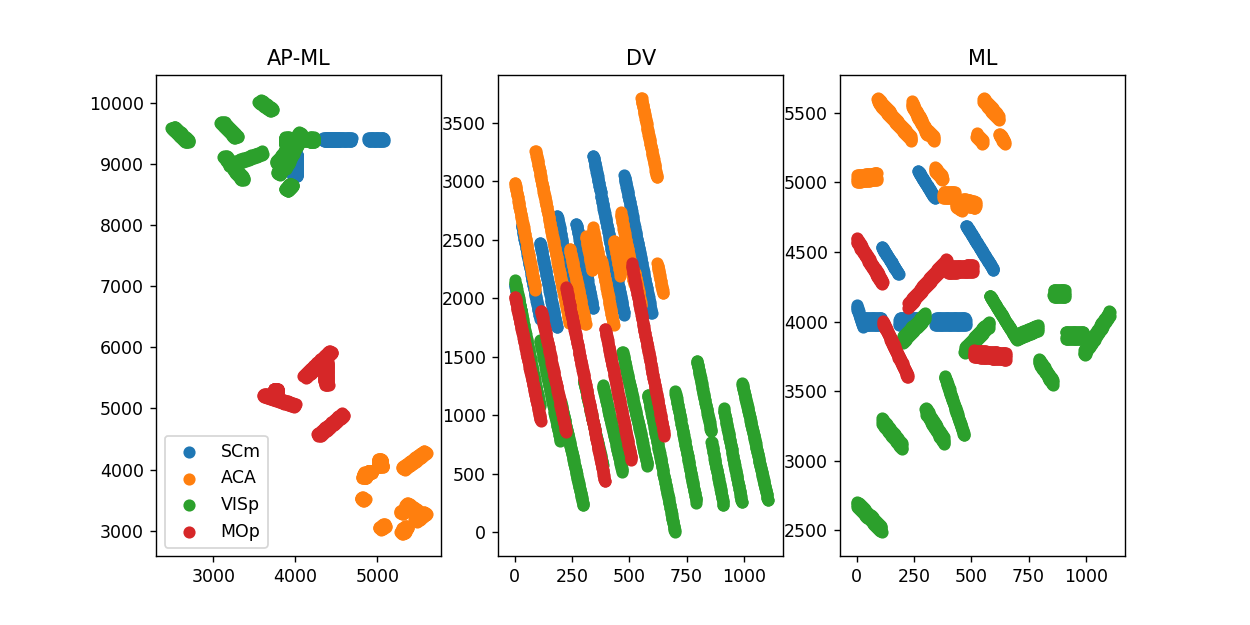

C:\Users\Le\Anaconda3b\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
C:\Users\Le\Anaconda3b\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Le\Anaconda3b\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reu

In [4]:
sublocs = master_locs[master_locs.allen_ontology == 'SCm']
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.scatter(sublocs.ccf_lr, sublocs.ccf_ap, label='SCm')
plt.title('AP-ML')
plt.subplot(132)
plt.scatter(np.arange(len(sublocs.ccf_dv)), sublocs.ccf_dv)
plt.title('DV')
plt.subplot(133)
plt.scatter(np.arange(len(sublocs.ccf_dv)), sublocs.ccf_lr)
plt.title('ML')

sublocs = master_locs[master_locs.allen_ontology == 'ACA']
#plt.figure()
plt.subplot(131)
plt.scatter(sublocs.ccf_lr, sublocs.ccf_ap, label='ACA')
plt.subplot(132)
plt.scatter(np.arange(len(sublocs.ccf_dv)), sublocs.ccf_dv)
plt.subplot(133)
plt.scatter(np.arange(len(sublocs.ccf_dv)), sublocs.ccf_lr)

sublocs = master_locs[master_locs.allen_ontology == 'VISp']
#plt.figure()
plt.subplot(131)
plt.scatter(sublocs.ccf_lr, sublocs.ccf_ap, label='VISp')
plt.subplot(132)
plt.scatter(np.arange(len(sublocs.ccf_dv)), sublocs.ccf_dv)
plt.subplot(133)
plt.scatter(np.arange(len(sublocs.ccf_dv)), sublocs.ccf_lr)

sublocs = master_locs[master_locs.allen_ontology == 'MOp']
#plt.figure()
plt.subplot(131)
plt.scatter(sublocs.ccf_lr, sublocs.ccf_ap, label='MOp')
plt.legend()

plt.subplot(132)
plt.scatter(np.arange(len(sublocs.ccf_dv)), sublocs.ccf_dv)
plt.subplot(133)
plt.scatter(np.arange(len(sublocs.ccf_dv)), sublocs.ccf_lr)



<IPython.core.display.Javascript object>


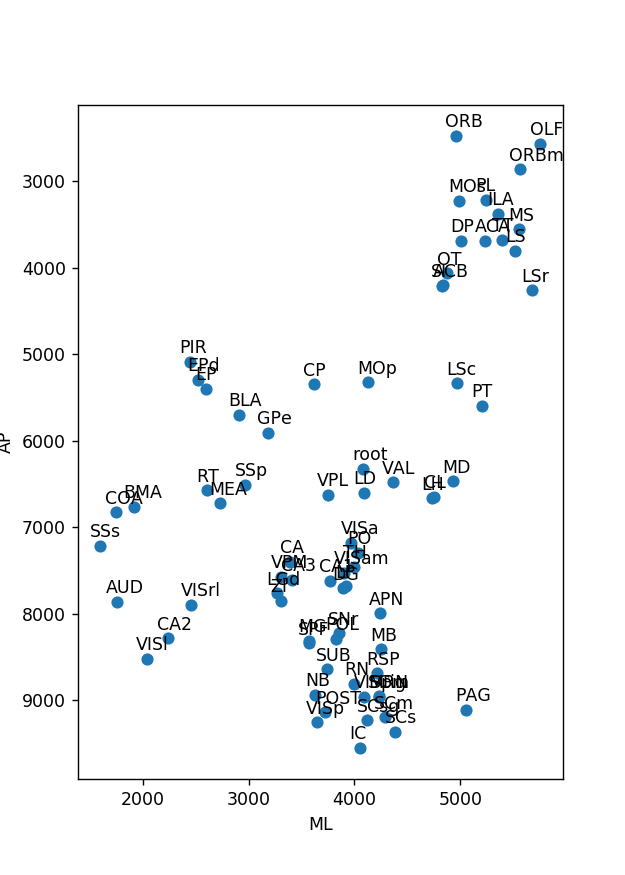

Text(0, 0.5, 'AP')

In [5]:
# Total number of units
area_mean = master_locs.groupby('allen_ontology')['ccf_ap', 'ccf_lr', 'ccf_dv'].mean().reset_index()
area_std = master_locs.groupby('allen_ontology')['ccf_ap', 'ccf_lr', 'ccf_dv'].std().reset_index()

plt.figure(figsize=(5, 7))
plt.scatter(area_mean.ccf_lr, area_mean.ccf_ap)
for i in range(area_mean.shape[0]):
    #print(i)
    plt.text(area_mean.ccf_lr[i] - 100, area_mean.ccf_ap[i] - 100, area_mean.allen_ontology[i], fontsize=10)
#plt.show()
plt.gca().invert_yaxis()
plt.xlabel('ML')
plt.ylabel('AP')

### Decision times

Here we calculate decision times based on wheel activity. This is done for all sessions.

In [6]:
def find_closest_choice_pts(tstim, choicepts):
    candidates = choicepts[choicepts > tstim - 0.1]
    return min(candidates)

def find_decision_times(stim_times, choice_points, choice_lst):
    closestChoicePt = []
    for idx, time in enumerate(stim_times):
        if choice_lst[idx] == 0:
            closest = np.nan
        else:
            closest = find_closest_choice_pts(time, choice_points)
        closestChoicePt.append(closest)
        #print('Trial: ', idx, ', stim on at ', time, ', closest: ', closest)
    return closestChoicePt

In [8]:
# for session in all_sess:
#     #directory = 'Radnitz_2017-01-09'
#     _,directory,_ = session.split('\\')
#     print(directory)
#     trials_stim_times = np.load(os.path.join('Data', directory, 'trials.visualStim_times.npy'))[:,0]
#     trials_choice = np.load(os.path.join('Data', directory, 'trials.response_choice.npy'))[:,0]
    
#     trials_wheel = np.load(os.path.join('Data', directory, 'wheel.position.npy'))[:,0]
#     wheel_tstamps = np.load(os.path.join('Data', directory, 'wheel.timestamps.npy'))
#     wheelMoveType = np.load(os.path.join('Data', directory, 'wheelMoves.type.npy'))[:,0]
#     wheelMoveIntervals = np.load(os.path.join('Data', directory, 'wheelMoves.intervals.npy'))
#     tstampsInterp = np.linspace(wheel_tstamps[0,1], wheel_tstamps[1,1], len(trials_wheel))
#     choicePoints = wheelMoveIntervals[(wheelMoveType == 1) | (wheelMoveType == 2), 0]
#     closestChoicePt = []
#     decision_times = find_decision_times(trials_stim_times, choicePoints, trials_choice)
#     np.save(os.path.join('Data', directory, 'trials.decision_times.npy'), decision_times)

### Recording locations

In [9]:
merged_tbls = []
for session in all_sess:
    _,directory,_ = session.split('\\')

    # Location information
    locations = pd.read_csv(os.path.join('Data', directory, 'channels.brainLocation.tsv'), sep='\t')
    locations['locIdx'] = locations.index - locations.index[0] + 1
    assert(min(locations['locIdx']) == 1)

    # Cluster information
    clusters_annotation = np.load(os.path.join('Data', directory, 'clusters._phy_annotation.npy'))[:,0]
    clusters_peakChannel = np.load(os.path.join('Data', directory, 'clusters.peakChannel.npy'))[:,0]
    clusters_brainLoc = locations.allen_ontology[clusters_peakChannel]
    clusters_fr = pd.DataFrame({'annotation': clusters_annotation, 'peakChannel': clusters_peakChannel,
                               'clusterIdx': np.arange(len(clusters_peakChannel))})
    
    # Merge
    merged_tbl = pd.merge(clusters_fr, locations, right_on='locIdx', left_on='peakChannel')
    merged_tbl['directory'] = directory
    
    merged_tbls.append(merged_tbl)
    #print(clusters_peakChannel.max(), clusters_peakChannel.min(), locations.shape[0])


In [11]:
# Count the number of units in each area
master_merged_tbls = pd.concat(merged_tbls)
area_count = master_merged_tbls[master_merged_tbls.annotation >= 2].groupby('allen_ontology')['ccf_ap'].count()
#pd.DataFrame(area_count).head(40)

In [12]:
master_merged_tbls[(master_merged_tbls.annotation >= 2) & (master_merged_tbls.directory == 'Cori_2016-12-14') & 
                  (master_merged_tbls.allen_ontology == 'ACA')]

,annotation,peakChannel,clusterIdx,ccf_ap,ccf_dv,ccf_lr,allen_ontology,locIdx,directory
0,3.0,224.0,0,4090.0,2445.4,5012.4,ACA,224,Cori_2016-12-14
1,3.0,224.0,133,4090.0,2445.4,5012.4,ACA,224,Cori_2016-12-14
4,3.0,172.0,2,4172.1,2979.3,5018.3,ACA,172,Cori_2016-12-14
13,3.0,250.0,350,4053.4,2188.3,5033.0,ACA,250,Cori_2016-12-14
19,3.0,241.0,7,4069.2,2267.4,5063.3,ACA,241,Cori_2016-12-14
73,3.0,225.0,23,4092.9,2425.6,5060.4,ACA,225,Cori_2016-12-14
75,3.0,225.0,141,4092.9,2425.6,5060.4,ACA,225,Cori_2016-12-14
76,3.0,225.0,146,4092.9,2425.6,5060.4,ACA,225,Cori_2016-12-14
80,3.0,256.0,26,4042.5,2129.0,5018.2,ACA,256,Cori_2016-12-14
83,3.0,256.0,205,4042.5,2129.0,5018.2,ACA,256,Cori_2016-12-14


### Save good units and their areas

In [13]:
#pd.DataFrame.to_csv(master_merged_tbls, 'labeled_clusters_all_session.csv')

### Load classified result
We now load the results as processed by the GLM

In [15]:
glmdata = scipy.io.loadmat('compiled_allGLMResults_04272020.mat')

In [44]:
def make_ks_frame(ks_filename):
    ksdata = scipy.io.loadmat(ks_filename)
    clustIDs = ksdata['clustIDs'][0]
    rawFolderNames = ksdata['foldernames'][0]
    foldernames = []
    for i in rawFolderNames:
        foldernames.append(i[0])
    pvallst = ksdata['pvallst'][0]
    totalspikes = ksdata['totalSpikes'][0]
    ksFrame = pd.DataFrame({'clustIDs': clustIDs, 'pvals': pvallst, 
                            'totalSpikes': totalspikes, 'folder': foldernames}) 
    return ksFrame

def make_glm_frame(glm_filename):
    glmdata = scipy.io.loadmat(glm_filename)
    dataArea = np.array(glmdata['area'])[0]
    dataClusterID = glmdata['clusterID'][0]
    dataDir = glmdata['directory'][0]
    sigLeft = glmdata['sigCellsLeft'][0]
    sigRight = glmdata['sigCellsRight'][0]
    sigPun = glmdata['sigCellsPun'][0]
    sigRew = glmdata['sigCellsRew'][0]
    sigStim = glmdata['sigCellsStim'][0]
    print('Number of units =', dataArea.shape[0])

    area = parse_data_str_lst(dataArea)
    directory = parse_data_str_lst(dataDir)
    
    glmtbl = pd.DataFrame({'area': area, 'directory': directory, 'clusterID': dataClusterID,
                      'left': sigLeft, 'right': sigRight, 'reward': sigRew, 'punish': sigPun, 'stimulus': sigStim})
    return glmtbl
        
def parse_data_str_lst(rawdata):
    lst = []
    for elem in rawdata:
        lst.append(elem[0])
    return lst

In [54]:
ksframe_ACA = make_ks_frame('kstestresults_ACC_05032020.mat')
ksframe_VISp = make_ks_frame('kstestresults_VISp_05032020.mat')
ksframe_SCm = make_ks_frame('kstestresults_SCm_05032020.mat')
ksmerge = pd.concat([ksframe_ACA, ksframe_VISp, ksframe_SCm])
ksmerge.shape

(2315, 4)

In [66]:
glmframe = make_glm_frame('compiled_allGLMResults_05032020.mat')

# Merge with master
glmMerge = pd.merge(master_merged_tbls, glmtbl, left_on=['directory', 'clusterIdx'],
                   right_on=['directory', 'clusterID'], how='right')
glmMerge = pd.merge(glmMerge, ksmerge, left_on=['directory', 'clusterIdx'], 
                    right_on=['folder', 'clustIDs'], how='right')
glmMerge.head()
glmMerge.area.unique()

Number of units = 2315


array(['ACA', 'VISp', 'SCm'], dtype=object)

In [67]:
glmACAstimulus = glmMerge[(glmMerge.area == 'ACA') & (glmMerge.stimulus)]
glmACAreward = glmMerge[(glmMerge.area == 'ACA') & (glmMerge.reward)]
glmVISpreward = glmMerge[((glmMerge.area == 'VISp') | (glmMerge.area == 'VISam') | (glmMerge.area == 'VISpm')) & (glmMerge.reward)]
glmVISpstimulus = glmMerge[((glmMerge.area == 'VISp') | (glmMerge.area == 'VISam') | (glmMerge.area == 'VISpum')) & (glmMerge.stimulus)]

<IPython.core.display.Javascript object>


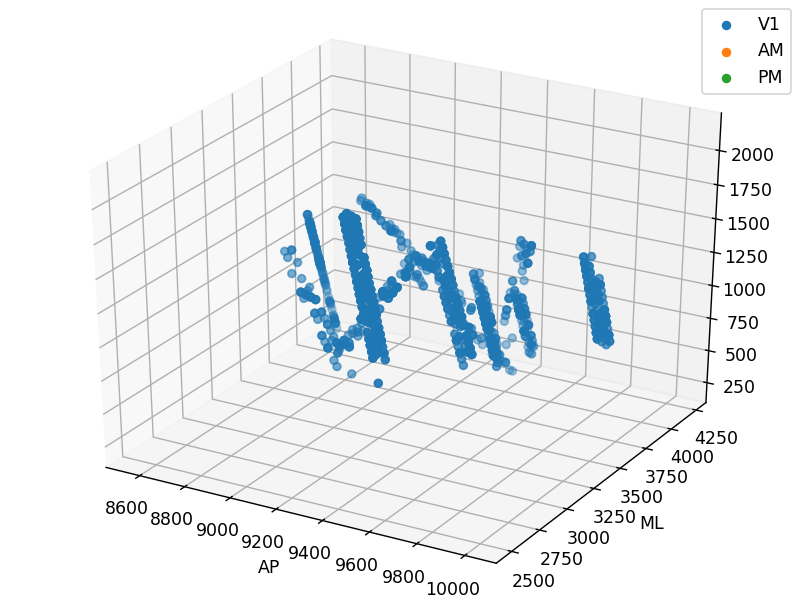

In [68]:
# Where are VISp, VISam and VISpm?
glmVISp = glmMerge[glmMerge.area == 'VISp']
glmVISam = glmMerge[glmMerge.area == 'VISam']
glmVISpm = glmMerge[glmMerge.area == 'VISpm']
glmACA = glmMerge[glmMerge.area == 'ACA']

fig = plt.figure()
ax = Axes3D(fig)
#ax.scatter(glmACAstimulus.ccf_ap, glmACAstimulus.ccf_lr, glmACAstimulus.ccf_dv, alpha=0.5)
#ax.scatter(glmACAreward.ccf_ap, glmACAreward.ccf_lr, glmACAreward.ccf_dv, alpha=0.5)

ax.scatter(glmVISp.ccf_ap, glmVISp.ccf_lr, glmVISp.ccf_dv, label='V1')
ax.scatter(glmVISam.ccf_ap, glmVISam.ccf_lr, glmVISam.ccf_dv, label='AM')
ax.scatter(glmVISpm.ccf_ap, glmVISpm.ccf_lr, glmVISpm.ccf_dv, label='PM')

plt.xlabel('AP')
plt.ylabel('ML')
plt.legend()


In [69]:
def get_filtered_counts(areaFrame):
    stimFrame = areaFrame[areaFrame.stimulus == 1]
    rewFrame = areaFrame[areaFrame.reward == 1]
    countsStim, xbins, ybins = np.histogram2d(stimFrame.ccf_lr, stimFrame.ccf_ap, bins=40)
    countsRew, xbins, ybins = np.histogram2d(rewFrame.ccf_lr, rewFrame.ccf_ap, bins=40)
    filteredStim = scipy.ndimage.gaussian_filter(countsStim, sigma=2)
    filteredRew = scipy.ndimage.gaussian_filter(countsRew, sigma=2)
    filteredDiff = scipy.ndimage.gaussian_filter(countsStim - countsRew, sigma=2)
    return filteredStim, filteredRew, filteredDiff, xbins, ybins

<IPython.core.display.Javascript object>


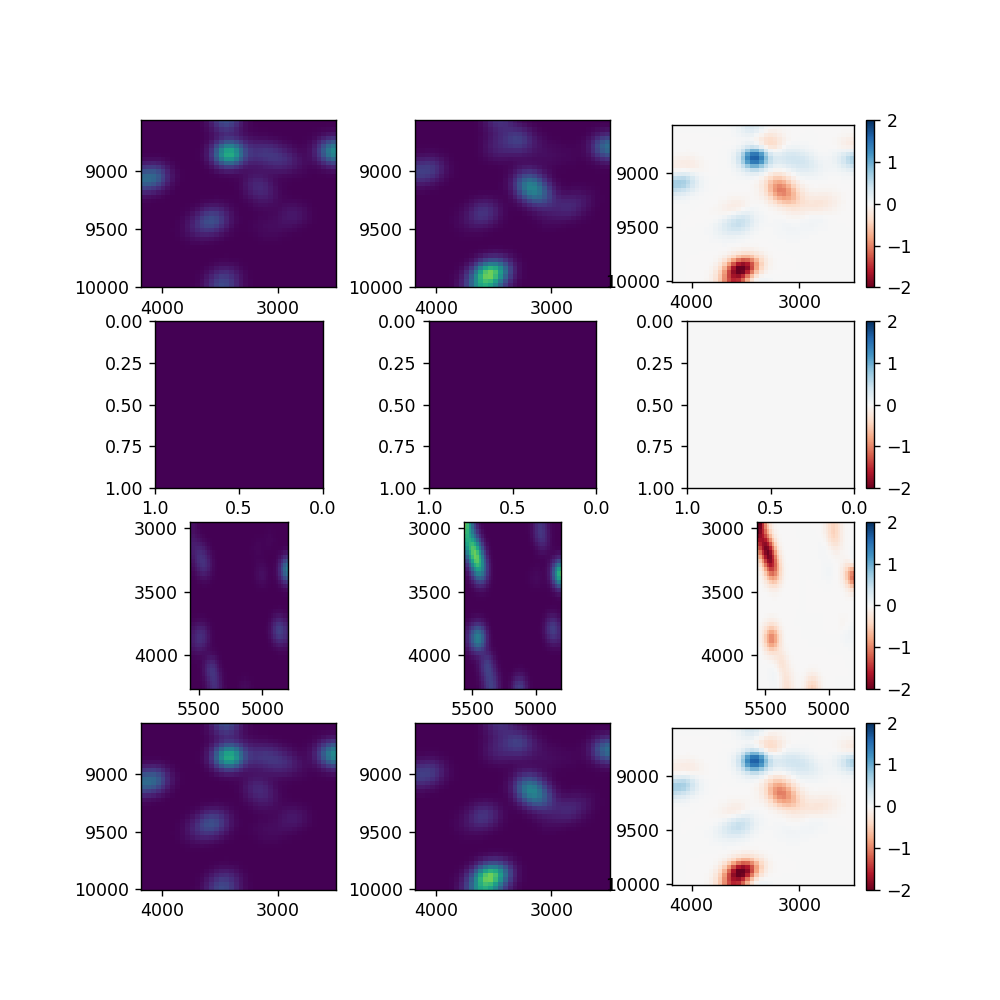

In [70]:
countV1Stim, countV1Rew, countV1Diff, xbinsV1, ybinsV1 = get_filtered_counts(glmVISp)
countACAStim, countACARew, countACADiff, xbinsACA, ybinsACA = get_filtered_counts(glmACA)
countAMStim, countAMRew, countAMDiff, xbinsAM, ybinsAM = get_filtered_counts(glmVISam)
countPMStim, countPMRew, countPMDiff, xbinsPM, ybinsPM = get_filtered_counts(glmVISpm)
countVISStim, countVISRew, countVISDiff, xbinsVIS, ybinsVIS = get_filtered_counts(pd.concat([glmVISp, glmVISam, glmVISpm]))

# V1
plt.figure(figsize=(8,8))
plt.subplot(431)
plt.imshow(countV1Stim, vmin=0, vmax=3, extent=[xbinsV1[0], xbinsV1[-1], ybinsV1[0], ybinsV1[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.subplot(432)
plt.imshow(countV1Rew, vmin=0, vmax=3, extent=[xbinsV1[0], xbinsV1[-1], ybinsV1[0], ybinsV1[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.subplot(433)
plt.imshow(countV1Diff, cmap='RdBu', vmin=-2, vmax=2, extent=[xbinsV1[0], xbinsV1[-1], ybinsV1[0], ybinsV1[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()

# AM
plt.subplot(434)
plt.imshow(countAMStim, vmin=0, vmax=3, extent=[xbinsAM[0], xbinsAM[-1], ybinsAM[0], ybinsAM[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.subplot(435)
plt.imshow(countAMRew, vmin=0, vmax=3, extent=[xbinsAM[0], xbinsAM[-1], ybinsAM[0], ybinsAM[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.subplot(436)
plt.imshow(countAMDiff, cmap='RdBu', vmin=-2, vmax=2, extent=[xbinsAM[0], xbinsAM[-1], ybinsAM[0], ybinsAM[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()

# PM
plt.subplot(437)
plt.imshow(countACAStim, vmin=0, vmax=3, extent=[xbinsACA[0], xbinsACA[-1], ybinsACA[0], ybinsACA[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.subplot(438)
plt.imshow(countACARew, vmin=0, vmax=3, extent=[xbinsACA[0], xbinsACA[-1], ybinsACA[0], ybinsACA[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()


plt.subplot(439)
plt.imshow(countACADiff, cmap='RdBu', vmin=-2, vmax=2, extent=[xbinsACA[0], xbinsACA[-1], ybinsACA[0], ybinsACA[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()

# Combined
plt.subplot(4,3,10)
plt.imshow(countVISStim, vmin=0, vmax=3, extent=[xbinsVIS[0], xbinsVIS[-1], ybinsVIS[0], ybinsVIS[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.subplot(4,3,11)
plt.imshow(countVISRew, vmin=0, vmax=3, extent=[xbinsVIS[0], xbinsVIS[-1], ybinsVIS[0], ybinsVIS[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()


plt.subplot(4,3,12)
plt.imshow(countVISDiff, cmap='RdBu', vmin=-2, vmax=2, extent=[xbinsVIS[0], xbinsVIS[-1], ybinsVIS[0], ybinsVIS[-1]])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.colorbar()

<IPython.core.display.Javascript object>


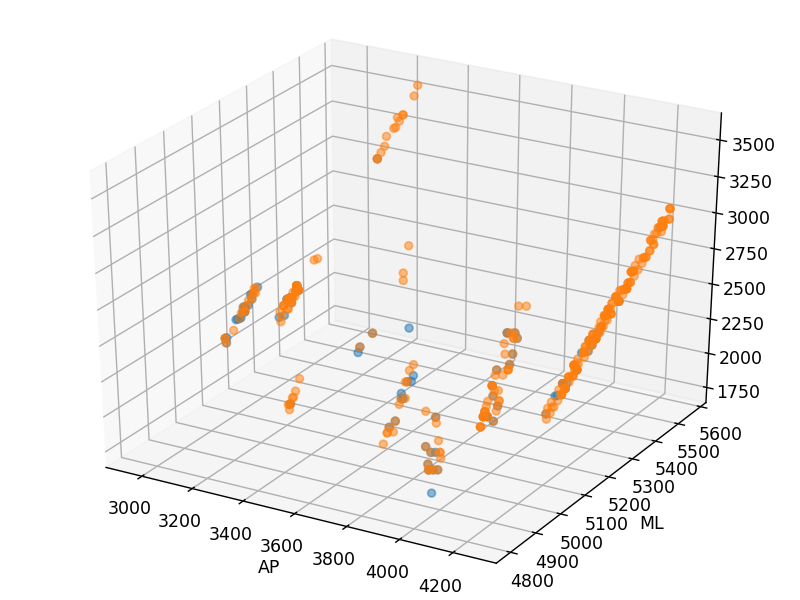

Text(0.5, 0, 'ML')

In [71]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(glmACAstimulus.ccf_ap, glmACAstimulus.ccf_lr, glmACAstimulus.ccf_dv, alpha=0.5)
ax.scatter(glmACAreward.ccf_ap, glmACAreward.ccf_lr, glmACAreward.ccf_dv, alpha=0.5)

#ax.scatter(glmVISpstimulus.ccf_ap, glmVISpstimulus.ccf_lr, glmVISpstimulus.ccf_dv)
#ax.scatter(glmVISpreward.ccf_ap, glmVISpreward.ccf_lr, glmVISpreward.ccf_dv)

plt.xlabel('AP')
plt.ylabel('ML')

In [72]:
def find_units_with_criteria(subtbl, criteria):
    left_subset = np.logical_xor(subtbl.left, criteria[0])
    right_subset = np.logical_xor(subtbl.right, criteria[1])
    reward_subset = np.logical_xor(subtbl.reward, criteria[2])
    punish_subset = np.logical_xor(subtbl.punish, criteria[3])
    stim_subset = np.logical_xor(subtbl.stimulus, criteria[4])

    
    combined = (~stim_subset) & (~left_subset) & (~right_subset) & (~reward_subset) & (~punish_subset)
    return np.where(combined)[0]

In [85]:
glmMerge.shape

(2315, 20)

In [86]:
def plot_area_units(area, tbl):
    subtbl = tbl[(tbl.area == area)]
    ntotal = subtbl.shape[0]
    
    subtbl = subtbl[tbl.pvals > 0.05]
    arr = np.array(subtbl[['left', 'right', 'reward', 'punish', 'stimulus']])
    ngood = subtbl.shape[0]
    print('Number of units =', ntotal, '. Number good =', ngood, 'Percentage =', ngood / ntotal * 100)
    numUnits = subtbl.shape[0]
    
    criteria_lst = [[1,0,0,0,0],
                   [0,1,0,0,0],
                   [0,0,1,0,0],
                   [0,0,0,1,0],
                   [0,0,0,0,1]]
    all_singles = []
    lenarrs = []
    
    combi_arr = np.zeros((5,5))
    for i in range(5):
        for j in range(5):
            if i <= j:
                criterion = np.zeros(5)
                criterion[i] = 1
                criterion[j] = 1
                filtered = find_units_with_criteria(subtbl, criterion)
                combi_arr[j,i] = len(filtered)
                plt.text(i-0.3, j, '%.1f %%' % (len(filtered) / numUnits * 100))
            else:
                combi_arr[j,i] = np.nan
            
    combi_arr = combi_arr / numUnits
    print(combi_arr)
            
    
    for criterion in criteria_lst:
        filtered = find_units_with_criteria(subtbl, criterion)
        all_singles.append(filtered)
        lenarrs.append(len(filtered))   
   
    order = np.argsort(lenarrs)
    #print(lenarrs)
    #print(order)
    
    arr2 = arr[np.concatenate((all_singles[order[0]], all_singles[order[1]], 
                              all_singles[order[2]], all_singles[order[3]], all_singles[order[4]])), :]

    print('Area:', area)
    #print('Total units = %d; stim only = %d; left only = %d; right only = %d; reward only = %d, punish only = %d\n' %
    # (arr.shape[0], len(stimOnly), len(leftOnly), len(rightOnly), len(rewardOnly), len(punishOnly)))
    
    #plt.figure()
    plt.rcParams['font.size'] = 12
    plt.rcParams['font.family'] = 'helvetica'
    plt.imshow(combi_arr, aspect='auto',cmap='Reds', vmin=0, vmax=0.2)
    plt.yticks(np.arange(5), ['left', 'right', 'reward', 'punish', 'stimulus'])
    plt.xticks(np.arange(5), ['left', 'right', 'reward', 'punish', 'stimulus'])
    plt.title(area)
    plt.colorbar()
    
    #ax.invert_yaxis()
    #plt.text(1,1, 'hi')
    
    return combi_arr

<IPython.core.display.Javascript object>


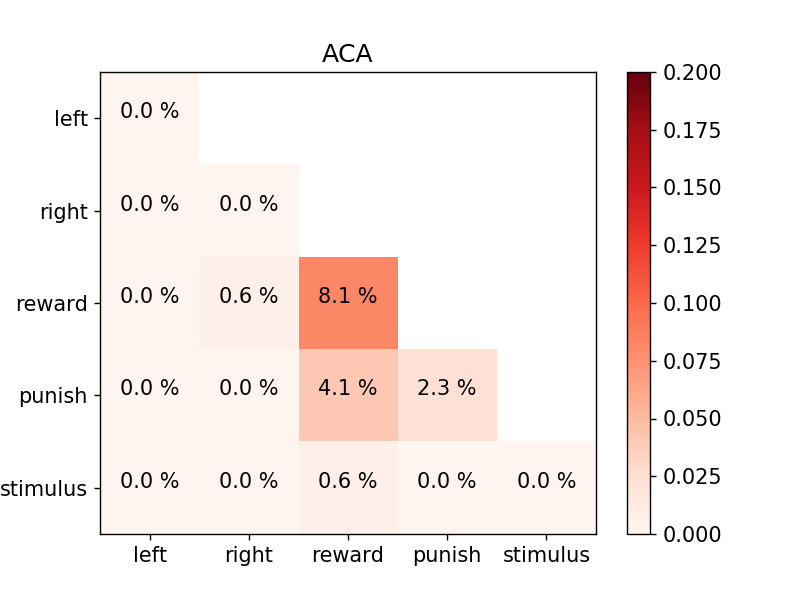

C:\Users\Le\Anaconda3b\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


Number of units = 841 . Number good = 172 Percentage = 20.451843043995243
[[0.                nan        nan        nan        nan]
 [0.         0.                nan        nan        nan]
 [0.         0.00581395 0.08139535        nan        nan]
 [0.         0.         0.04069767 0.02325581        nan]
 [0.         0.         0.00581395 0.         0.        ]]
Area: ACA


In [90]:
plt.figure()
plot_area_units('ACA', glmMerge)
plt.savefig('ACA_summary_05032020.pdf')

<IPython.core.display.Javascript object>


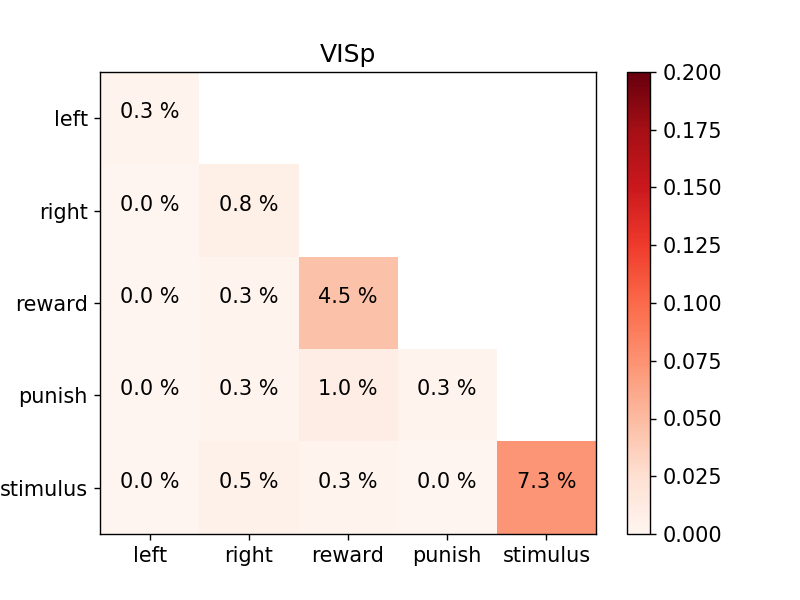

Number of units = 1118 . Number good = 396 Percentage = 35.42039355992844
[[0.00252525        nan        nan        nan        nan]
 [0.         0.00757576        nan        nan        nan]
 [0.         0.00252525 0.04545455        nan        nan]
 [0.         0.00252525 0.01010101 0.00252525        nan]
 [0.         0.00505051 0.00252525 0.         0.07323232]]
Area: VISp


C:\Users\Le\Anaconda3b\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [91]:
plt.figure()
plot_area_units('VISp', glmMerge)
plt.savefig('VISp_summary_05032020.pdf')

<IPython.core.display.Javascript object>


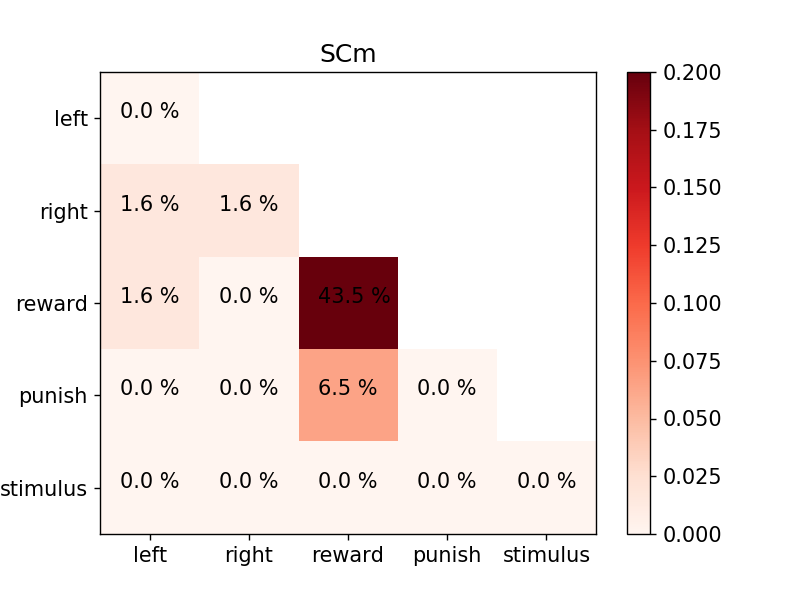

Number of units = 356 . Number good = 62 Percentage = 17.415730337078653
[[0.                nan        nan        nan        nan]
 [0.01612903 0.01612903        nan        nan        nan]
 [0.01612903 0.         0.43548387        nan        nan]
 [0.         0.         0.06451613 0.                nan]
 [0.         0.         0.         0.         0.        ]]
Area: SCm


C:\Users\Le\Anaconda3b\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [92]:
plt.figure()
plot_area_units('SCm', glmMerge)
plt.savefig('SCm_summary_05032020.pdf')

<IPython.core.display.Javascript object>


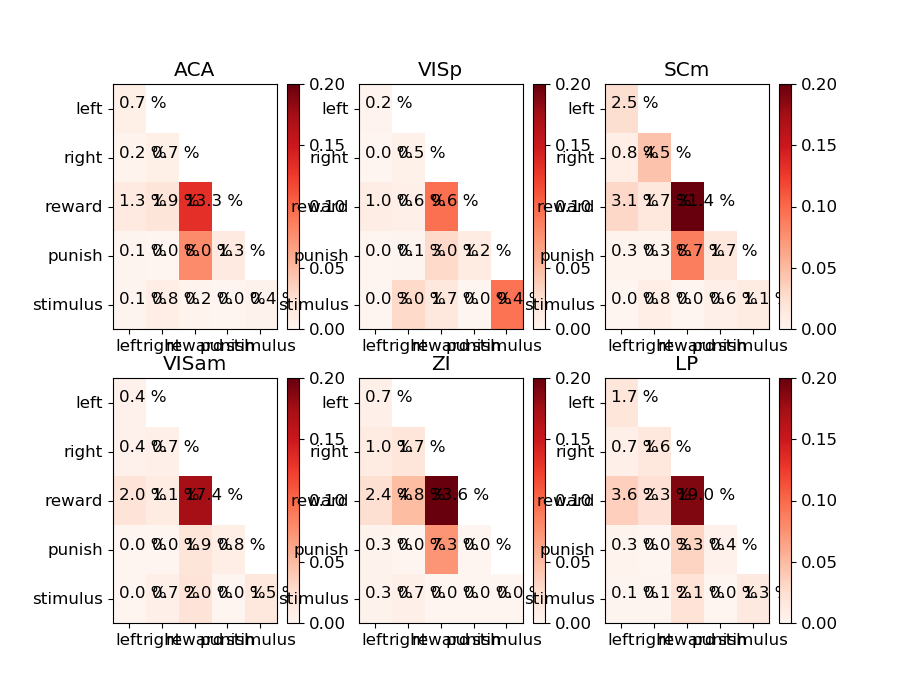

[[0.00713436        nan        nan        nan        nan]
 [0.00237812 0.00713436        nan        nan        nan]
 [0.01307967 0.01902497 0.13317479        nan        nan]
 [0.00118906 0.         0.07966706 0.01307967        nan]
 [0.00118906 0.00832342 0.00237812 0.         0.00356718]]
Area: ACA
[[0.00178891        nan        nan        nan        nan]
 [0.         0.00536673        nan        nan        nan]
 [0.009839   0.00626118 0.09570662        nan        nan]
 [0.         0.00089445 0.02951699 0.01162791        nan]
 [0.         0.02951699 0.01699463 0.         0.09391771]]
Area: VISp
[[0.02521008        nan        nan        nan        nan]
 [0.00840336 0.04481793        nan        nan        nan]
 [0.03081232 0.01680672 0.31372549        nan        nan]
 [0.00280112 0.00280112 0.08683473 0.01680672        nan]
 [0.         0.00840336 0.         0.00560224 0.01120448]]
Area: SCm
[[0.003996          nan        nan        nan        nan]
 [0.003996   0.00699301        nan    

array([[0.01737968,        nan,        nan,        nan,        nan],
       [0.00668449, 0.01604278,        nan,        nan,        nan],
       [0.03609626, 0.02272727, 0.18983957,        nan,        nan],
       [0.0026738 , 0.        , 0.03342246, 0.0040107 ,        nan],
       [0.0013369 , 0.0013369 , 0.02139037, 0.        , 0.01336898]])

In [29]:
plt.figure(figsize=(9,7))
plt.subplot(231)
plot_area_units('ACA', glmMerge)
plt.subplot(232)
plot_area_units('VISp', glmMerge)
plt.subplot(233)
plot_area_units('SCm', glmMerge)
plt.subplot(234)
plot_area_units('VISam', glmMerge)
plt.subplot(235)
plot_area_units('ZI', glmMerge)
plt.subplot(236)
plot_area_units('LP', glmMerge)
#plt.subplot(236)
#plot_area_units('VISrl', glmMerge)

In [32]:
subtbl = glmMerge[glmMerge.area == 'ACA']

In [33]:
subtbl

,annotation,peakChannel,clusterIdx,ccf_ap,ccf_dv,ccf_lr,allen_ontology,locIdx,directory,area,clusterID,left,right,reward,punish,stimulus
0,3.0,224.0,0,4090.0,2445.4,5012.4,ACA,224,Cori_2016-12-14,ACA,0,0,0,0,0,0
1,3.0,224.0,133,4090.0,2445.4,5012.4,ACA,224,Cori_2016-12-14,ACA,133,0,0,0,0,0
2,3.0,172.0,2,4172.1,2979.3,5018.3,ACA,172,Cori_2016-12-14,ACA,2,1,0,1,0,0
3,3.0,250.0,350,4053.4,2188.3,5033.0,ACA,250,Cori_2016-12-14,ACA,350,0,0,0,0,0
4,3.0,241.0,7,4069.2,2267.4,5063.3,ACA,241,Cori_2016-12-14,ACA,7,0,0,0,0,0
5,3.0,225.0,23,4092.9,2425.6,5060.4,ACA,225,Cori_2016-12-14,ACA,23,0,0,0,0,0
6,3.0,225.0,141,4092.9,2425.6,5060.4,ACA,225,Cori_2016-12-14,ACA,141,0,0,0,0,0
7,3.0,225.0,146,4092.9,2425.6,5060.4,ACA,225,Cori_2016-12-14,ACA,146,0,0,0,0,0
8,3.0,256.0,26,4042.5,2129.0,5018.2,ACA,256,Cori_2016-12-14,ACA,26,0,0,0,0,0
9,3.0,256.0,205,4042.5,2129.0,5018.2,ACA,256,Cori_2016-12-14,ACA,205,0,0,0,0,0


In [34]:
pvals = scipy.io.loadmat('kstestresults_ACA.mat')

In [38]:
pvals = pvals['pvallst'][0]

In [40]:
subtbl['pvals'] = pvals

C:\Users\Le\Anaconda3b\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
subtbl

,annotation,peakChannel,clusterIdx,ccf_ap,ccf_dv,ccf_lr,allen_ontology,locIdx,directory,area,clusterID,left,right,reward,punish,stimulus,pvals
0,3.0,224.0,0,4090.0,2445.4,5012.4,ACA,224,Cori_2016-12-14,ACA,0,0,0,0,0,0,7.349804e-01
1,3.0,224.0,133,4090.0,2445.4,5012.4,ACA,224,Cori_2016-12-14,ACA,133,0,0,0,0,0,8.014512e-01
2,3.0,172.0,2,4172.1,2979.3,5018.3,ACA,172,Cori_2016-12-14,ACA,2,1,0,1,0,0,2.136724e-21
3,3.0,250.0,350,4053.4,2188.3,5033.0,ACA,250,Cori_2016-12-14,ACA,350,0,0,0,0,0,6.835095e-02
4,3.0,241.0,7,4069.2,2267.4,5063.3,ACA,241,Cori_2016-12-14,ACA,7,0,0,0,0,0,4.500230e-02
5,3.0,225.0,23,4092.9,2425.6,5060.4,ACA,225,Cori_2016-12-14,ACA,23,0,0,0,0,0,1.799198e-06
6,3.0,225.0,141,4092.9,2425.6,5060.4,ACA,225,Cori_2016-12-14,ACA,141,0,0,0,0,0,1.496452e-04
7,3.0,225.0,146,4092.9,2425.6,5060.4,ACA,225,Cori_2016-12-14,ACA,146,0,0,0,0,0,3.804289e-04
8,3.0,256.0,26,4042.5,2129.0,5018.2,ACA,256,Cori_2016-12-14,ACA,26,0,0,0,0,0,1.163456e-02
9,3.0,256.0,205,4042.5,2129.0,5018.2,ACA,256,Cori_2016-12-14,ACA,205,0,0,0,0,0,2.070557e-03


In [42]:
goodclust = subtbl[subtbl.pvals > 0.05]

In [52]:
goodclust.sort_values(by=['directory','clusterIdx'])

,annotation,peakChannel,clusterIdx,ccf_ap,ccf_dv,ccf_lr,allen_ontology,locIdx,directory,area,clusterID,left,right,reward,punish,stimulus,pvals
0,3.0,224.0,0,4090.0,2445.4,5012.4,ACA,224,Cori_2016-12-14,ACA,0,0,0,0,0,0,0.734980
10,3.0,259.0,28,4036.6,2089.4,5019.0,ACA,259,Cori_2016-12-14,ACA,28,0,0,0,0,0,0.702375
16,3.0,211.0,35,4112.7,2583.8,5025.7,ACA,211,Cori_2016-12-14,ACA,35,0,0,0,0,0,0.064540
30,3.0,210.0,73,4116.6,2583.8,5057.4,ACA,210,Cori_2016-12-14,ACA,73,0,0,0,0,0,0.621070
33,3.0,235.0,79,4076.1,2326.7,5046.3,ACA,235,Cori_2016-12-14,ACA,79,0,0,1,0,0,0.142721
48,3.0,248.0,107,4054.4,2208.1,5016.8,ACA,248,Cori_2016-12-14,ACA,107,1,0,1,0,0,0.072156
53,3.0,212.0,110,4111.7,2564.0,5041.9,ACA,212,Cori_2016-12-14,ACA,110,0,0,0,0,0,0.341741
1,3.0,224.0,133,4090.0,2445.4,5012.4,ACA,224,Cori_2016-12-14,ACA,133,0,0,0,0,0,0.801451
66,3.0,220.0,169,4099.8,2484.9,5043.4,ACA,220,Cori_2016-12-14,ACA,169,0,0,0,0,0,0.063532
72,3.0,197.0,203,4131.5,2722.2,5007.2,ACA,197,Cori_2016-12-14,ACA,203,0,0,1,0,0,0.145411


In [44]:
badclust = subtbl[subtbl.pvals < 0.05]

In [53]:
badclust.sort_values(by=['directory','clusterIdx'])

,annotation,peakChannel,clusterIdx,ccf_ap,ccf_dv,ccf_lr,allen_ontology,locIdx,directory,area,clusterID,left,right,reward,punish,stimulus,pvals
2,3.0,172.0,2,4172.1,2979.3,5018.3,ACA,172,Cori_2016-12-14,ACA,2,1,0,1,0,0,2.136724e-21
4,3.0,241.0,7,4069.2,2267.4,5063.3,ACA,241,Cori_2016-12-14,ACA,7,0,0,0,0,0,4.500230e-02
5,3.0,225.0,23,4092.9,2425.6,5060.4,ACA,225,Cori_2016-12-14,ACA,23,0,0,0,0,0,1.799198e-06
8,3.0,256.0,26,4042.5,2129.0,5018.2,ACA,256,Cori_2016-12-14,ACA,26,0,0,0,0,0,1.163456e-02
15,3.0,208.0,47,4117.7,2603.6,5041.2,ACA,208,Cori_2016-12-14,ACA,47,0,0,0,0,0,1.373714e-15
17,3.0,214.0,53,4110.7,2544.3,5058.2,ACA,214,Cori_2016-12-14,ACA,53,0,0,0,0,0,4.155293e-03
18,3.0,206.0,59,4122.6,2623.4,5056.7,ACA,206,Cori_2016-12-14,ACA,59,0,0,0,0,0,5.438783e-14
19,3.0,245.0,67,4063.2,2227.9,5064.0,ACA,245,Cori_2016-12-14,ACA,67,1,1,1,1,0,2.091743e-05
21,3.0,196.0,68,4135.5,2722.2,5039.0,ACA,196,Cori_2016-12-14,ACA,68,1,0,1,0,0,1.357202e-03
24,3.0,222.0,72,4098.8,2465.2,5059.6,ACA,222,Cori_2016-12-14,ACA,72,1,1,1,1,0,1.664649e-04


In [97]:
glmMerge[(glmMerge.area == 'VISp')  & (glmMerge.folder == 'Radnitz_2017-01-08')]

,annotation,peakChannel,clusterIdx,ccf_ap,ccf_dv,ccf_lr,allen_ontology,locIdx,directory,area,clusterID,left,right,reward,punish,stimulus,clustIDs,pvals,totalSpikes,folder
1560,2.0,728.0,652,9406.3,430.5,4176.0,VISp,728,Radnitz_2017-01-08,VISp,652,0,0,0,0,0,652,9.480767e-01,36,Radnitz_2017-01-08
1561,2.0,728.0,711,9406.3,430.5,4176.0,VISp,728,Radnitz_2017-01-08,VISp,711,0,0,0,0,0,711,9.752824e-01,10,Radnitz_2017-01-08
1562,2.0,728.0,955,9406.3,430.5,4176.0,VISp,728,Radnitz_2017-01-08,VISp,955,0,0,0,0,0,955,1.119528e-01,24,Radnitz_2017-01-08
1563,2.0,701.0,670,9362.5,707.0,4176.0,VISp,701,Radnitz_2017-01-08,VISp,670,0,0,0,0,0,670,8.276509e-01,112,Radnitz_2017-01-08
1564,2.0,701.0,680,9362.5,707.0,4176.0,VISp,701,Radnitz_2017-01-08,VISp,680,0,0,0,0,0,680,2.673101e-01,227,Radnitz_2017-01-08
1565,2.0,701.0,721,9362.5,707.0,4176.0,VISp,701,Radnitz_2017-01-08,VISp,721,0,0,0,0,0,721,6.050100e-02,417,Radnitz_2017-01-08
1566,2.0,701.0,761,9362.5,707.0,4176.0,VISp,701,Radnitz_2017-01-08,VISp,761,0,0,0,0,0,761,1.513945e-01,36,Radnitz_2017-01-08
1567,2.0,701.0,882,9362.5,707.0,4176.0,VISp,701,Radnitz_2017-01-08,VISp,882,0,1,0,0,1,882,1.309587e-02,1061,Radnitz_2017-01-08
1568,2.0,701.0,1141,9362.5,707.0,4176.0,VISp,701,Radnitz_2017-01-08,VISp,1141,0,0,0,0,0,1141,8.878293e-01,35,Radnitz_2017-01-08
1569,2.0,737.0,672,9418.8,351.5,4208.0,VISp,737,Radnitz_2017-01-08,VISp,672,0,0,0,0,0,672,2.694597e-01,92,Radnitz_2017-01-08
